<a href="https://colab.research.google.com/github/peeyushsinghal/CNN/blob/master/CNN_Basic_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Exploring to create CNN through basic libraries

Architecture : Input Layer -> Conv Layer 1 -> Relu 1 ->  Maxpool layer -> Dense (Fully Connected) Layer -> Ouput

1. Import Libraries

In [142]:
import numpy as np
import matplotlib.pyplot as plt # for showing images
import tensorflow as tf # only for importing keras dataset
import random # for generating random number (image index)
import tensorflow.keras.datasets.mnist

2. Getting data : Importing the dataset - MNIST hand written digits https://keras.io/api/datasets/mnist/. 



In [143]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz")
# Tuple of Numpy arrays: (x_train, y_train), (x_test, y_test)
#x_train: uint8 arrays of grayscale image data with shapes (num_samples, 28, 28).
#y_train: uint8 arrays of digit labels (integers in range 0-9) with shapes (num_samples,)

In [144]:
# Checking the downloaded data, using a subset only
train_img = x_train[:1000] # around 1500 images for training
train_label = y_train[:1000]
test_img = x_train[:100] # around 1500 images for training
test_label = y_test[0:100]
train_img.shape


(1000, 28, 28)

Label:  0


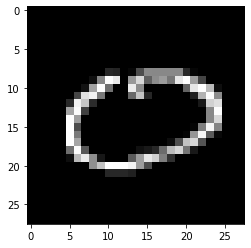

In [145]:
# visualizing the data
n = random.randint(0,train_img.shape[0]-1)# generated a random integer between 0 and image index
img = train_img[n].reshape((28, 28)) # using the index, get the image reshaped to 28, 28, [ understood by stackoverflow comments]
label = train_label[n] # the label for the corresponding index
print("Label: ",label)
plt.imshow(img, cmap='gray')
plt.show()

3. Breaking the CNN into 3 part - a. Convolution, b. Max Pool and 3. Softmax layer

Looking at A. Convolution Operation

In [146]:
class conv:

  def __init__(self,num_filter,filter_size):
    self.num_filter = num_filter
    self.filter_size = filter_size # assuming square filter, we don't need other size
    self.conv_filter = np.random.randn(num_filter,filter_size,filter_size)/(filter_size*filter_size) # random initialitization

  def image_patch(self,image): # generator function to generate image patches to put into convolution function
    height,width = image.shape # please note first param is height and next is width
    self.image = image
    for i in range(height-self.filter_size+1):
      for j in range (width-self.filter_size+1):
        image_region = image[i:(i+self.filter_size),j:(j+self.filter_size)]
        yield image_region, i, j 

  def forward_propogation(self,image):
    height,width = image.shape
    conv_output = np.zeros((height-self.filter_size+1,width-self.filter_size+1,self.num_filter))
    for img_patch, i, j in self.image_patch(image):
      conv_output[i,j]= np.sum(img_patch*self.conv_filter,axis=(1,2))
    return conv_output

  def backward_propogation(self, dL_dout,lr):
    dL_dF_params = np.zeros(self.conv_filter.shape)
    for img_patch, i, j in self.image_patch(self.image):
      for k in range(self.num_filter):
        dL_dF_params[k] = dL_dF_params[k] + img_patch*dL_dout[i,j,k]
    # Filter Param update
    self.conv_filter =  self.conv_filter-lr*dL_dF_params
    return dL_dF_params

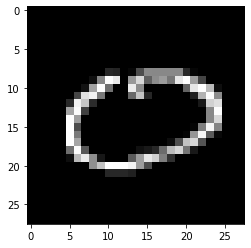

In [147]:
plt.imshow(img, cmap='gray')
plt.show()

In [148]:
# checking forward propogation
cnn = conv(8,5)
cnn_fwd_output = cnn.forward_propogation(img)
cnn_fwd_output.shape
# 24 = 28-(5) +1, 8 = number of filters

(24, 24, 8)

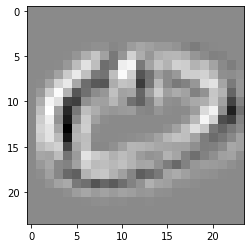

In [149]:
plt.imshow(cnn_fwd_output[:,:,6], cmap='gray')
plt.show()
# showing filter 7 (7-1 = 6)

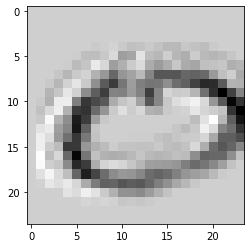

In [150]:
plt.imshow(cnn_fwd_output[:,:,5], cmap='gray')
plt.show()
# showing filter 6 (6-1 = 5)


Looking at B. Max Pool



In [151]:
class max_pool:
  def __init__(self,filter_size):
    self.filter_size = filter_size # filter size is the size as how we want to scale down the image. 1/filter_size would be downsizing

  def image_patch(self,image): # generator function to generate image patches to put into max pool forward fuction
    new_height = image.shape[0] // self.filter_size # the new height of the image
    new_width = image.shape[1] // self.filter_size # the new width of the image
    self.image = image 
    for i in range(new_height):
      for j in range (new_width):
        image_region = image[(i*self.filter_size):(i*self.filter_size+self.filter_size),(j*self.filter_size):(j*self.filter_size+self.filter_size)]
        yield image_region, i, j

  def forward_propogation(self,image):
    height,width,num_filters = image.shape # please note that the depth of the image would also contain filter size after conv processing
    max_pool_output = np.zeros((height // self.filter_size, width // self.filter_size, num_filters))

    for img_patch, i, j in self.image_patch(image):
      max_pool_output[i,j]= np.amax(img_patch,axis=(0,1))
    return max_pool_output

  def backward_propogation(self, dL_dout): # please note that there is no update of gradient in max pool
    dL_dmax_pool = np.zeros(self.image.shape)
    for img_patch, i, j in self.image_patch(self.image):
      height, width, num_filters = img_patch.shape
      maximum_val = np.amax(img_patch,axis=(0,1))

      for i1 in range(height):
        for j1 in range(width):
          for k1 in range(num_filters):
            if img_patch[i1,j1,k1] == maximum_val[k1]:
              dL_dmax_pool[i*self.filter_size+i1, j*self.filter_size+j1, k1] = dL_dout[i,j,k1]
      # there are no weights and biases asssociated with max pool operation and hence no updates
      return dL_dmax_pool

In [152]:
m_pool = max_pool(2)
m_pool_output = m_pool.forward_propogation(cnn_fwd_output)
m_pool_output.shape
# reduction of size by 2

(12, 12, 8)

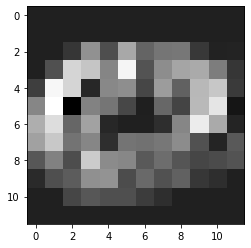

In [153]:
plt.imshow(m_pool_output[:,:,6], cmap='gray')
plt.show()
# showing filter 7 (7-1 = 6)

Looking at C. Soft Max

In [154]:
class Softmax:
  def __init__(self,input_node, softmax_node):
    self.weight = np.random.randn(input_node, softmax_node) # random initialitization
    self.bias = np.zeros(softmax_node)

  def forward_propogation(self,image):
    self.orig_img_shape = image.shape
    image_modified = image.flatten()
    self.modified_input = image_modified

    output_val = np.dot(image_modified,self.weight)+self.bias
    self.out = output_val
    exp_out = np.exp(output_val)
    return (exp_out/np.sum(exp_out, axis=0))

  def backward_propogation(self, dL_dout,lr): 
    for i, grad in enumerate(dL_dout):
      if grad ==0:
        continue
      transformation_eq = np.exp(self.out)
      S_total = np.sum(transformation_eq)

      # Gradients with respect to out (z)
      dy_dz = -transformation_eq[i]*transformation_eq / (S_total**2)
      dy_dz[i] = transformation_eq[i]*(S_total-transformation_eq[i]) / (S_total**2)

      # Gradients of totals with respect to weights /biases / input
      dz_dw  =self.modified_input
      dz_db = 1
      dz_d_inp = self.weight

      # Gradients of loss with respect to totals
      dL_dz = grad * dy_dz

      # Gradients of loss with respect to weights /biases / input
      dL_dw = dz_dw[np.newaxis].T @ dL_dz[np.newaxis]
      dL_db = dL_dz * dz_db
      dL_d_inp = dz_d_inp @ dL_dz

    # Weight and bias update
    self.weight =  self.weight - lr * dL_dw
    self.bias = self.bias - lr * dL_db

    return dL_d_inp.reshape(self.orig_img_shape)



In [155]:
input_dim_softmax = m_pool_output.shape[0] * m_pool_output.shape[1] * m_pool_output.shape[2]
print(input_dim_softmax)

1152


In [156]:
soft_max = Softmax(input_dim_softmax,10)
soft_max_output = soft_max.forward_propogation(m_pool_output)
print(soft_max_output)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0. nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Writing main function to conv, max pool and backprop

In [157]:
conv_object= conv(8,5)  # 28x28x1 => 24x24x8
pool_object = max_pool(2) # 24x24x8 => 12x12x8
soft_max_object = Softmax(12*12*8,10) # 12x12x8 => 10

In [158]:
def cnn_forward_propogation(image,label):
  output_f_p = conv_object.forward_propogation((image/255)-0.5)
  output_f_p = pool_object.forward_propogation(output_f_p)
  output_f_p = soft_max_object.forward_propogation(output_f_p)

  # Calculating cross entropy loss and accuracy

  cross_entropy_loss = -np.log(output_f_p[label])
  accuracy = 1 if np.argmax(output_f_p) == label else 0
  return output_f_p, cross_entropy_loss, accuracy


In [159]:
def training_cnn(image,label, lr = 0.005):
  # From forward propopgation
  output_f_p, cross_entropy_loss, accuracy = cnn_forward_propogation (image,label)

  # Calculation of initial gradient
  gradient = np.zeros(10)
  gradient[label] = -1 / output_f_p[label]

  # Backpropogation
  grad_back_prop = soft_max_object.backward_propogation(gradient,lr)
  grad_back_prop = pool_object.backward_propogation(grad_back_prop)
  grad_back_prop = conv_object.backward_propogation(grad_back_prop,lr)

  return cross_entropy_loss, accuracy

In [160]:
for epoch in range(2):
  print(' Epoch ----%d----',epoch + 1)

  #Shuffle training data
  shuffle_data = np.random.permutation(len(train_img))
  train_img = train_img[shuffle_data]
  train_label = train_label[shuffle_data]

  # Training
  loss = 0
  num_correct = 0
  for i,(im,label) in enumerate(zip(train_img,train_label)):
    if i % 100 == 0:
      print ('loss: ',loss/100)
      print("Accuracy ", num_correct)
      loss = 0
      num_correct = 0
    l1, accu = training_cnn(im,label)
    loss = loss + l1
    num_correct = num_correct + accu

  # testing cnn
  print ("-------Testing Phase------")
  loss = 0
  num_correct = 0
  for im,label in enumerate(zip(test_img,test_label)):
    _, l1, accu = cnn_forward_propogation(im,label)
    loss = loss + l1
    num_correct = num_correct + accu
  
  num_tests = len(test_img)
  print ('Test Loss: ', loss/num_tests)
  print ('Test Accuracy: ', num_correct / num_tests)



 Epoch ----%d---- 1
loss:  0.0
Accuracy  0
loss:  34.15102272352379
Accuracy  17
loss:  24.18056061112161
Accuracy  20
loss:  16.532004551031683
Accuracy  31
loss:  14.464410614776723
Accuracy  31
loss:  12.30282893666649
Accuracy  37
loss:  10.977287648648922
Accuracy  36
loss:  10.430694330988864
Accuracy  38
loss:  7.211846370269075
Accuracy  58
loss:  6.324937185042063
Accuracy  55
-------Testing Phase------


AttributeError: ignored